In [1]:
import os
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import imagesize
from torchvision import datasets, models, transforms
import seaborn as sns
from PIL import Image
from PIL.ImageFile import ImageFile
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.profiler import profile, record_function, ProfilerActivity
import optuna
from efficientnet_pytorch import EfficientNet

In [2]:
#vars
ImageFile.LOAD_TRUNCATED_IMAGES = True

#batch_size = 128
n_epochs = 15
num_trials = 70
validation_split = .25
images_for_train = 30000
print_every = 100

name_training = "efficient3_hyperparameters_wi"
os.mkdir(name_training)

In [3]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:

ImageFile.LOAD_TRUNCATED_IMAGES = True
print(device)
print(torch.cuda.get_device_name(3))

cuda:3
NVIDIA RTX A6000


In [4]:
data_path = "data"
#data_path = "D:\Studium\OneDrive - Hochschule Karlsruhe\own-pictures"

image = []
labels = []
width = []
height = []

for file in os.listdir(data_path):
    # if file == 'elektromuell':
    #     for c in os.listdir(os.path.join(data_path, file)):
    #         image.append(c)
    #         labels.append('elektromuell')
    #         w, h = imagesize.get(data_path + "/" + file + "/" + c)
    #         width.append(w), height.append(h)
    if file == 'glas':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('glas')
            w, h = imagesize.get(data_path + "/" + file + "/" + c)
            width.append(w), height.append(h)
    if file == 'organic':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('organic')
            w, h = imagesize.get(data_path + "/" + file + "/" + c)
            width.append(w), height.append(h)
    if file == 'paper':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('paper')
            w, h = imagesize.get(data_path + "/" + file + "/" + c)
            width.append(w), height.append(h)
    if file == 'restmuell':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('restmuell')
            w, h = imagesize.get(data_path + "/" + file + "/" + c)
            width.append(w), height.append(h)
    if file == 'wertstoff':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('wertstoff')
            w, h = imagesize.get(data_path + "/" + file + "/" + c)
            width.append(w), height.append(h)

data = {'Images': image, 'labels': labels, 'width': width, 'height': height}
data = pd.DataFrame(data)
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

In [5]:
data = data.sample(frac=1).reset_index(drop=True)
data = data.head(images_for_train)
tr, val = train_test_split(data, stratify=data.labels, test_size=validation_split)
tr.reset_index(drop=True)
val.reset_index(drop=True)
print(val)

                            Images     labels  width  height  encoded_labels
4859                plastic174.jpg  wertstoff   3264    2448               4
18754             glass (4011).jpg       glas    199     253               0
6182          restmuell (8899).jpg  restmuell    220     229               3
1779                plastic120.jpg  wertstoff   3264    2448               4
8745              paper (6426).jpg      paper   5312    2988               2
...                            ...        ...    ...     ...             ...
2654          restmuell (1282).jpg  restmuell    400     533               3
11844  0097_a01b08c1d2e0f1g1h1.jpg  wertstoff   1920    1277               4
14773                 glass302.jpg       glas   4032    3024               0
5964          restmuell (8339).jpg  restmuell    400     533               3
2573              paper (3900).jpg      paper   4032    3024               2

[5691 rows x 5 columns]


In [6]:
waste_types_df = tr[['encoded_labels', 'labels']].drop_duplicates().sort_values(by='encoded_labels').reset_index(drop=True)
garbage_types = {}
for i in range(0, len(waste_types_df)):
    garbage_types[i] = waste_types_df.iloc[i].labels
print(garbage_types)

{0: 'glas', 1: 'organic', 2: 'paper', 3: 'restmuell', 4: 'wertstoff'}


In [7]:
data

,Images,labels,width,height,encoded_labels
0,paper323.jpg,paper,4032,3024,2
1,glass (6018).jpg,glas,194,259,0
2,glass (2903).jpg,glas,382,382,0
3,organic (7454).jpg,organic,400,300,1
4,organic (5807).jpg,organic,224,224,1
...,...,...,...,...,...
22759,IMG_20220331_201254.jpg,wertstoff,2976,2976,4
22760,restmuell (4482).jpg,restmuell,400,533,3
22761,restmuell (6603).jpg,restmuell,720,1280,3
22762,signal-2022-03-20-172507_014.jpg,wertstoff,2048,945,4


In [8]:
from torchvision import transforms

transform_tr = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     #transforms.RandomRotation(10),
     transforms.Resize((256,256), interpolation= transforms.InterpolationMode.BICUBIC),
     #transforms.CenterCrop(290),
     #transforms.Resize((300,300), interpolation= transforms.InterpolationMode.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
transform_val = transforms.Compose(
    [transforms.Resize((256,256), interpolation= transforms.InterpolationMode.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

In [9]:
from torch.utils.data import Dataset

class GarbageDataset(Dataset):
    def __init__(self, img_data, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        img_name = os.path.join(self.img_path, self.img_data.iloc[index].labels, self.img_data.iloc[index].Images)
        image = Image.open(img_name).convert('RGB')
        #image = image.resize((300, 300))
        label = torch.tensor(self.img_data.iloc[index].encoded_labels)
        if self.transform is not None:
            image = self.transform(image)
        return image, label, img_name

In [10]:
from torch.utils.data import DataLoader

train_dataset = GarbageDataset(tr, data_path, transform_tr)
test_dataset = GarbageDataset(val, data_path, transform_val)


In [11]:
import numpy as np

def img_display(img):
    MEAN = torch.tensor([0.485, 0.456, 0.406])
    STD = torch.tensor([0.229, 0.224, 0.225])

    img = img * STD[:, None, None] + MEAN[:, None, None]
    #img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg


In [12]:
def accuracy(out, labels):
    _, pred = torch.max(out, dim=1)
    return torch.sum(pred == labels).item()

In [13]:
def get_model(model_name):
    if model_name == "resnet18":
        model = models.resnet18(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, len(waste_types_df))
    elif model_name == "alexnet":
        model = models.alexnet(pretrained=True)
        in_features = model.classifier[1].in_features
        model.classifier = nn.Linear(in_features, len(waste_types_df))
    elif model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        in_features = model.classifier[0].in_features
        model.classifier = nn.Linear(in_features, len(waste_types_df))
    elif model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, len(waste_types_df))
    elif model_name == "efficientnet_b3":
        model = EfficientNet.from_pretrained("efficientnet-b3",num_classes=len(waste_types_df))
    elif model_name == "resnet34":
        model = models.resnet34(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, len(waste_types_df))
    return model


def objective(trial):
    # Hyperparameters we want optimize
    params = {
        #"model_name": trial.suggest_categorical('model_name',["resnet50", "alexnet", "vgg16"]),
        "lr": trial.suggest_loguniform('lr', 1e-4, 1e-2),
        "optimizer_name": trial.suggest_categorical('optimizer_name', ["SGD", "Adam", "Adagrad", "RMSprop"]),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64, 128]),
    }
    #For SGD-Optimizer add momentum parameter

    # Get pretrained model
    model = get_model("efficientnet_b3")
    model = model.to(device)

    # Define criterion
    criterion = nn.CrossEntropyLoss()

    # Configure optimizer
    optimizer = getattr(torch.optim, params["optimizer_name"])(model.parameters(), lr=params["lr"])

    if params["optimizer_name"] == "SGD":
        params["momentum"] = trial.suggest_loguniform('momentum', 0.85, 0.95)
        # Configure optimizer again for SGD
        optimizer = getattr(torch.optim, params["optimizer_name"])(model.parameters(), lr=params["lr"],
                                                                   momentum=params["momentum"])

    # Train a model
    best_model, best_loss = train_model(trial, model, criterion, optimizer, num_epochs=n_epochs,
                                        b_size=params["batch_size"])

    # Return accuracy (Objective Value) of the current trial
    return best_loss

In [14]:
def train_model(trial, net, criterion, optimizer, num_epochs, b_size, step_size=7, gamma=0.1):
    train_dataloader = DataLoader(train_dataset, batch_size=b_size, shuffle=True, num_workers=7, pin_memory=True)
    test_dataloader = DataLoader(test_dataset, batch_size=b_size, shuffle=True, num_workers=7, pin_memory=True)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    val_loss = []
    val_acc = []
    train_loss = []
    train_acc = []
    valid_loss_min = np.Inf
    total_step = len(train_dataloader)

    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        correct = 0
        total = 0
        print(f'Epoch {epoch}\n')
        for batch_idx, (data_, target_, _) in enumerate(train_dataloader):
            target_ = target_.type(torch.LongTensor)
            data_, target_ = data_.to(device, non_blocking=True), target_.to(device, non_blocking=True)
            # zero the parameter gradients
            for param in net.parameters():
                param.grad = None
            #optimizer.zero_grad()
            outputs = net(data_)
            loss = criterion(outputs, target_)

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            _, pred = torch.max(outputs, dim=1)
            correct += torch.sum(pred == target_).item()
            total += target_.size(0)
            #if batch_idx % print_every == 0:
                #print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs, batch_idx, total_step, loss.item()))
        train_acc.append(100 * correct / total)
        train_loss.append(running_loss / total_step)
        print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
        batch_loss = 0
        total_t = 0
        correct_t = 0
        with torch.no_grad():
            net.eval()
            for data_t, target_t, _ in (test_dataloader):
                target_t = target_t.type(torch.LongTensor)
                data_t, target_t = data_t.to(device), target_t.to(device)  # on GPU
                outputs_t = net(data_t)
                loss_t = criterion(outputs_t, target_t)
                batch_loss += loss_t.item()
                _, pred_t = torch.max(outputs_t, dim=1)
                correct_t += torch.sum(pred_t == target_t).item()
                total_t += target_t.size(0)
            val_acc.append(100 * correct_t / total_t)
            val_loss.append(batch_loss / len(test_dataloader))
            network_learned = batch_loss < valid_loss_min
            print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
            # Saving the best weight
            if network_learned:
                valid_loss_min = batch_loss
                torch.save(net.state_dict(), name_training + '/resnet.pt')
                best_model = net
                best_acc = (100 * correct_t / total_t)
                best_loss = np.mean(val_loss)
                print('Detected network improvement, saving current model')

        net.train()
        exp_lr_scheduler.step()

        trial.report(best_loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_model, best_loss

In [15]:
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(
    sampler=sampler,
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=2, n_warmup_steps=5, interval_steps=3
    ),
    direction='minimize')
study.optimize(func=objective, n_trials=num_trials)

[I 2022-04-26 18:42:02,754] A new study created in memory with name: no-name-0784741c-472d-4466-9008-75c22791f51a


Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2652, train acc: 91.5539
validation loss: 0.1854, validation acc: 93.5864

Detected network improvement, saving current model
Epoch 2


train loss: 0.1643, train acc: 97.9734
validation loss: 0.1452, validation acc: 96.9250

Detected network improvement, saving current model
Epoch 3


train loss: 0.1220, train acc: 98.6880
validation loss: 0.1310, validation acc: 96.8547

Detected network improvement, saving current model
Epoch 4


train loss: 0.0996, train acc: 98.9281
validation loss: 0.1265, validation acc: 96.9425

Epoch 5


train loss: 0.0842, train acc: 99.2268
validation loss: 0.1243, validation acc: 96.7141

Epoch 6


train loss: 0.0739, train acc: 99.1976
validation loss: 0.1247, validation acc: 96.9601

Epoch 7


train loss: 0.0678, train acc: 98.9633
validation loss: 0.1259, validation acc: 96.4154

Epoch 8


train loss: 0.0606, train acc: 99.7071
validation loss: 0.1192, validation acc: 97.9266

Detected 

[I 2022-04-26 19:21:59,218] Trial 0 finished with value: 0.10552779570330086 and parameters: {'lr': 0.0003636995309229573, 'optimizer_name': 'Adam', 'batch_size': 128}. Best is trial 0 with value: 0.10552779570330086.


validation loss: 0.0958, validation acc: 98.1901

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.3321, train acc: 88.8596
validation loss: 0.0982, validation acc: 96.8020

Detected network improvement, saving current model
Epoch 2


train loss: 0.2309, train acc: 95.7652
validation loss: 0.0936, validation acc: 97.2061

Detected network improvement, saving current model
Epoch 3


train loss: 0.1810, train acc: 97.2823
validation loss: 0.0945, validation acc: 97.1534

Epoch 4


train loss: 0.1509, train acc: 98.1081
validation loss: 0.0916, validation acc: 97.3291

Detected network improvement, saving current model
Epoch 5


train loss: 0.1314, train acc: 98.3248
validation loss: 0.0932, validation acc: 96.8723

Epoch 6


train loss: 0.1160, train acc: 98.8403
validation loss: 0.0947, validation acc: 97.1885

Epoch 7


train loss: 0.1051, train acc: 98.7231
validation loss: 0.0945, validation acc: 97.2588

Epoch 8


train loss: 0.0944, train acc: 99.4319
validatio

[I 2022-04-26 20:05:22,677] Trial 1 finished with value: 0.08865770377945134 and parameters: {'lr': 0.00013565053352233603, 'optimizer_name': 'Adam', 'batch_size': 16}. Best is trial 1 with value: 0.08865770377945134.


validation loss: 0.0843, validation acc: 98.0496

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2166, train acc: 92.7546
validation loss: 0.1076, validation acc: 96.3627

Detected network improvement, saving current model
Epoch 2


train loss: 0.1406, train acc: 97.8211
validation loss: 0.1083, validation acc: 96.6087

Epoch 3


train loss: 0.1075, train acc: 98.6704
validation loss: 0.1113, validation acc: 96.2924

Epoch 4


train loss: 0.0884, train acc: 99.0218
validation loss: 0.1074, validation acc: 97.2764

Detected network improvement, saving current model
Epoch 5


train loss: 0.0745, train acc: 99.3499
validation loss: 0.1042, validation acc: 97.4697

Detected network improvement, saving current model
Epoch 6


train loss: 0.0662, train acc: 99.2327
validation loss: 0.1083, validation acc: 96.7668

Epoch 7


train loss: 0.0589, train acc: 99.4963
validation loss: 0.1084, validation acc: 97.5751

Epoch 8


train loss: 0.0527, train acc: 99.7364
validatio

[I 2022-04-26 20:33:30,852] Trial 2 pruned. 


validation loss: 0.0985, validation acc: 98.1901

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 1.5590, train acc: 41.3636
validation loss: 1.4328, validation acc: 44.0520

Detected network improvement, saving current model
Epoch 2


train loss: 1.3659, train acc: 52.6680
validation loss: 1.4785, validation acc: 51.3794

Epoch 3


train loss: 1.2468, train acc: 60.6396
validation loss: 1.3981, validation acc: 57.2307

Detected network improvement, saving current model
Epoch 4


train loss: 1.1572, train acc: 66.2039
validation loss: 1.7236, validation acc: 47.1622

Epoch 5


train loss: 1.0882, train acc: 69.8296


[I 2022-04-26 20:46:20,123] Trial 3 pruned. 


validation loss: 1.5848, validation acc: 65.2258

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.4065, train acc: 85.6089
validation loss: 0.3523, validation acc: 87.0849

Detected network improvement, saving current model
Epoch 2


train loss: 0.3042, train acc: 93.0592
validation loss: 0.2581, validation acc: 93.9905

Detected network improvement, saving current model
Epoch 3


train loss: 0.2493, train acc: 95.2147
validation loss: 0.2350, validation acc: 94.2892

Epoch 4


train loss: 0.2148, train acc: 96.3158
validation loss: 0.2083, validation acc: 96.2221

Detected network improvement, saving current model
Epoch 5


train loss: 0.1899, train acc: 96.9777


[I 2022-04-26 20:59:53,469] Trial 4 pruned. 


validation loss: 0.2009, validation acc: 95.4138

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.3363, train acc: 88.7425
validation loss: 0.1488, validation acc: 94.9394

Detected network improvement, saving current model
Epoch 2


train loss: 0.2279, train acc: 95.9117
validation loss: 0.1294, validation acc: 96.2045

Detected network improvement, saving current model
Epoch 3


train loss: 0.1737, train acc: 97.7918
validation loss: 0.1146, validation acc: 97.3115

Detected network improvement, saving current model
Epoch 4


train loss: 0.1412, train acc: 98.5357
validation loss: 0.1072, validation acc: 97.3115

Detected network improvement, saving current model
Epoch 5


train loss: 0.1196, train acc: 98.8403
validation loss: 0.1019, validation acc: 97.6454

Detected network improvement, saving current model
Epoch 6


train loss: 0.1041, train acc: 99.1038
validation loss: 0.0996, validation acc: 97.4170

Epoch 7


train loss: 0.0920, train acc: 99.4084
valida

[I 2022-04-26 21:46:40,643] Trial 5 finished with value: 0.08421611817555809 and parameters: {'lr': 0.003698593969320376, 'optimizer_name': 'SGD', 'batch_size': 32, 'momentum': 0.9327306688681064}. Best is trial 5 with value: 0.08421611817555809.


validation loss: 0.0788, validation acc: 98.2956

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2149, train acc: 92.6434
validation loss: 0.0956, validation acc: 96.6965

Detected network improvement, saving current model
Epoch 2


train loss: 0.1402, train acc: 97.8680
validation loss: 0.0820, validation acc: 97.9266

Detected network improvement, saving current model
Epoch 3


train loss: 0.1037, train acc: 99.0394
validation loss: 0.0769, validation acc: 98.0144

Detected network improvement, saving current model
Epoch 4


train loss: 0.0835, train acc: 99.2854
validation loss: 0.0748, validation acc: 98.0496

Epoch 5


train loss: 0.0699, train acc: 99.5783
validation loss: 0.0745, validation acc: 97.9090

Epoch 6


train loss: 0.0605, train acc: 99.6017
validation loss: 0.0747, validation acc: 97.9441

Epoch 7


train loss: 0.0535, train acc: 99.6427
validation loss: 0.0739, validation acc: 98.0847

Epoch 8


train loss: 0.0479, train acc: 99.7599
validatio

[I 2022-04-26 22:27:11,205] Trial 6 finished with value: 0.0710589576651881 and parameters: {'lr': 0.0019034151842556662, 'optimizer_name': 'Adagrad', 'batch_size': 64}. Best is trial 6 with value: 0.0710589576651881.


validation loss: 0.0701, validation acc: 98.3307

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.5982, train acc: 81.7841
validation loss: 0.2160, validation acc: 92.6551

Detected network improvement, saving current model
Epoch 2


train loss: 0.3955, train acc: 93.6215
validation loss: 0.1848, validation acc: 94.8867

Detected network improvement, saving current model
Epoch 3


train loss: 0.3038, train acc: 96.1108
validation loss: 0.1628, validation acc: 96.0464

Detected network improvement, saving current model
Epoch 4


train loss: 0.2486, train acc: 97.3115
validation loss: 0.1495, validation acc: 96.3802

Detected network improvement, saving current model
Epoch 5


train loss: 0.2112, train acc: 98.0144


[I 2022-04-26 22:40:40,862] Trial 7 pruned. 


validation loss: 0.1395, validation acc: 96.4681

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.3182, train acc: 90.7339
validation loss: 0.1384, validation acc: 95.9234

Detected network improvement, saving current model
Epoch 2


train loss: 0.2077, train acc: 97.1593
validation loss: 0.1179, validation acc: 96.9601

Detected network improvement, saving current model
Epoch 3


train loss: 0.1595, train acc: 98.1316
validation loss: 0.1084, validation acc: 97.0831

Detected network improvement, saving current model
Epoch 4


train loss: 0.1308, train acc: 98.6704
validation loss: 0.1034, validation acc: 97.1885

Detected network improvement, saving current model
Epoch 5


train loss: 0.1118, train acc: 98.9926


[I 2022-04-26 22:53:34,533] Trial 8 pruned. 


validation loss: 0.0996, validation acc: 97.2413

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.3304, train acc: 88.0045
validation loss: 0.1281, validation acc: 95.7652

Detected network improvement, saving current model
Epoch 2


train loss: 0.2396, train acc: 94.9569
validation loss: 0.1198, validation acc: 96.2572

Detected network improvement, saving current model
Epoch 3


train loss: 0.1904, train acc: 96.9308
validation loss: 0.1129, validation acc: 96.5384

Detected network improvement, saving current model
Epoch 4


train loss: 0.1612, train acc: 97.4990
validation loss: 0.1102, validation acc: 96.7141

Epoch 5


train loss: 0.1392, train acc: 98.2428


[I 2022-04-26 23:07:20,094] Trial 9 pruned. 


validation loss: 0.1140, validation acc: 95.9410

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2071, train acc: 92.9069
validation loss: 0.0913, validation acc: 96.9777

Detected network improvement, saving current model
Epoch 2


train loss: 0.1352, train acc: 97.8856
validation loss: 0.0836, validation acc: 97.3818

Detected network improvement, saving current model
Epoch 3


train loss: 0.1013, train acc: 98.9457
validation loss: 0.0787, validation acc: 97.8914

Detected network improvement, saving current model
Epoch 4


train loss: 0.0816, train acc: 99.3147
validation loss: 0.0753, validation acc: 98.1198

Detected network improvement, saving current model
Epoch 5


train loss: 0.0683, train acc: 99.6134
validation loss: 0.0733, validation acc: 98.1198

Epoch 6


train loss: 0.0589, train acc: 99.7189
validation loss: 0.0717, validation acc: 98.0671

Detected network improvement, saving current model
Epoch 7


train loss: 0.0520, train acc: 99.7130
valida

[I 2022-04-26 23:46:41,535] Trial 10 finished with value: 0.06548639226552636 and parameters: {'lr': 0.001974473004564208, 'optimizer_name': 'Adagrad', 'batch_size': 64}. Best is trial 10 with value: 0.06548639226552636.


validation loss: 0.0651, validation acc: 98.4186

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2115, train acc: 92.9011
validation loss: 0.0939, validation acc: 96.7493

Detected network improvement, saving current model
Epoch 2


train loss: 0.1363, train acc: 98.1023
validation loss: 0.0876, validation acc: 97.3291

Detected network improvement, saving current model
Epoch 3


train loss: 0.1019, train acc: 98.9281
validation loss: 0.0815, validation acc: 97.7333

Detected network improvement, saving current model
Epoch 4


train loss: 0.0819, train acc: 99.2854
validation loss: 0.0790, validation acc: 97.8035

Epoch 5


train loss: 0.0691, train acc: 99.4260
validation loss: 0.0765, validation acc: 97.9617

Detected network improvement, saving current model
Epoch 6


train loss: 0.0597, train acc: 99.6369
validation loss: 0.0753, validation acc: 97.8914

Epoch 7


train loss: 0.0527, train acc: 99.6837
validation loss: 0.0750, validation acc: 97.8738

Epoch 8

[I 2022-04-27 00:26:31,388] Trial 11 finished with value: 0.07652299222091652 and parameters: {'lr': 0.0020004846459955265, 'optimizer_name': 'Adagrad', 'batch_size': 64}. Best is trial 10 with value: 0.06548639226552636.


validation loss: 0.0712, validation acc: 98.0320

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2135, train acc: 92.9596
validation loss: 0.0868, validation acc: 97.1885

Detected network improvement, saving current model
Epoch 2


train loss: 0.1390, train acc: 97.9734
validation loss: 0.0783, validation acc: 97.7860

Detected network improvement, saving current model
Epoch 3


train loss: 0.1049, train acc: 98.8988
validation loss: 0.0755, validation acc: 97.7860

Detected network improvement, saving current model
Epoch 4


train loss: 0.0859, train acc: 99.0980
validation loss: 0.0735, validation acc: 97.9441

Detected network improvement, saving current model
Epoch 5


train loss: 0.0723, train acc: 99.4904
validation loss: 0.0718, validation acc: 98.0144

Detected network improvement, saving current model
Epoch 6


train loss: 0.0625, train acc: 99.6720
validation loss: 0.0707, validation acc: 98.1023

Detected network improvement, saving current model
Epoc

[I 2022-04-27 01:07:22,227] Trial 12 finished with value: 0.06700401595085434 and parameters: {'lr': 0.0015923632878780492, 'optimizer_name': 'Adagrad', 'batch_size': 64}. Best is trial 10 with value: 0.06548639226552636.


validation loss: 0.0640, validation acc: 98.3483

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2336, train acc: 92.5789
validation loss: 0.1007, validation acc: 96.5735

Detected network improvement, saving current model
Epoch 2


train loss: 0.1547, train acc: 97.7098
validation loss: 0.0904, validation acc: 97.2764

Detected network improvement, saving current model
Epoch 3


train loss: 0.1178, train acc: 98.7407
validation loss: 0.0850, validation acc: 97.6103

Detected network improvement, saving current model
Epoch 4


train loss: 0.0963, train acc: 99.1390
validation loss: 0.0816, validation acc: 97.8035

Detected network improvement, saving current model
Epoch 5


train loss: 0.0820, train acc: 99.2913


[I 2022-04-27 01:20:53,461] Trial 13 pruned. 


validation loss: 0.0789, validation acc: 97.8563

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2200, train acc: 92.5086
validation loss: 0.0988, validation acc: 96.7844

Detected network improvement, saving current model
Epoch 2


train loss: 0.1398, train acc: 98.2018
validation loss: 0.0865, validation acc: 97.3291

Detected network improvement, saving current model
Epoch 3


train loss: 0.1046, train acc: 98.9281
validation loss: 0.0806, validation acc: 97.6981

Detected network improvement, saving current model
Epoch 4


train loss: 0.0838, train acc: 99.4377
validation loss: 0.0768, validation acc: 98.0671

Detected network improvement, saving current model
Epoch 5


train loss: 0.0703, train acc: 99.5490
validation loss: 0.0757, validation acc: 97.8211

Epoch 6


train loss: 0.0611, train acc: 99.5783
validation loss: 0.0746, validation acc: 97.9968

Epoch 7


train loss: 0.0542, train acc: 99.6076
valida

[I 2022-04-27 01:59:02,378] Trial 14 pruned. 


validation loss: 0.0711, validation acc: 98.0144

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2949, train acc: 91.1849
validation loss: 0.1284, validation acc: 96.0112

Detected network improvement, saving current model
Epoch 2


train loss: 0.2005, train acc: 96.7083
validation loss: 0.1135, validation acc: 96.8371

Detected network improvement, saving current model
Epoch 3


train loss: 0.1587, train acc: 97.6805
validation loss: 0.1043, validation acc: 97.1534

Detected network improvement, saving current model
Epoch 4


train loss: 0.1324, train acc: 98.4127
validation loss: 0.0985, validation acc: 97.4873

Detected network improvement, saving current model
Epoch 5


train loss: 0.1147, train acc: 98.7700


[I 2022-04-27 02:12:29,440] Trial 15 pruned. 


validation loss: 0.0946, validation acc: 97.4873

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2329, train acc: 91.9522
validation loss: 0.0999, validation acc: 96.7844

Detected network improvement, saving current model
Epoch 2


train loss: 0.1473, train acc: 97.8797
validation loss: 0.0957, validation acc: 97.0480

Detected network improvement, saving current model
Epoch 3


train loss: 0.1108, train acc: 98.7641
validation loss: 0.0905, validation acc: 97.5927

Detected network improvement, saving current model
Epoch 4


train loss: 0.0875, train acc: 99.4963
validation loss: 0.0878, validation acc: 97.7157

Detected network improvement, saving current model
Epoch 5


train loss: 0.0731, train acc: 99.5080


[I 2022-04-27 02:26:01,483] Trial 16 pruned. 


validation loss: 0.0866, validation acc: 97.5927

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2316, train acc: 92.4384
validation loss: 0.1001, validation acc: 96.6438

Detected network improvement, saving current model
Epoch 2


train loss: 0.1521, train acc: 97.7215
validation loss: 0.0887, validation acc: 97.5048

Detected network improvement, saving current model
Epoch 3


train loss: 0.1172, train acc: 98.5474
validation loss: 0.0833, validation acc: 97.6278

Detected network improvement, saving current model
Epoch 4


train loss: 0.0953, train acc: 99.2503
validation loss: 0.0803, validation acc: 97.7508

Detected network improvement, saving current model
Epoch 5


train loss: 0.0816, train acc: 99.1917


[I 2022-04-27 02:39:47,095] Trial 17 pruned. 


validation loss: 0.0778, validation acc: 97.9441

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2986, train acc: 89.6913
validation loss: 0.1570, validation acc: 95.0097

Detected network improvement, saving current model
Epoch 2


train loss: 0.2246, train acc: 94.9042
validation loss: 0.2213, validation acc: 90.2829

Epoch 3


train loss: 0.1880, train acc: 96.1870
validation loss: 0.1970, validation acc: 95.4490

Detected network improvement, saving current model
Epoch 4


train loss: 0.1619, train acc: 97.1065
validation loss: 0.1881, validation acc: 95.0448

Epoch 5


train loss: 0.1453, train acc: 97.3174


[I 2022-04-27 02:52:59,016] Trial 18 pruned. 


validation loss: 0.1784, validation acc: 95.6247

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2201, train acc: 92.4501
validation loss: 0.1146, validation acc: 95.8882

Detected network improvement, saving current model
Epoch 2


train loss: 0.1471, train acc: 97.4638
validation loss: 0.1056, validation acc: 96.8020

Detected network improvement, saving current model
Epoch 3


train loss: 0.1164, train acc: 98.2253
validation loss: 0.1045, validation acc: 96.7141

Epoch 4


train loss: 0.0969, train acc: 98.6997
validation loss: 0.1053, validation acc: 96.8547

Epoch 5


train loss: 0.0836, train acc: 99.0628


[I 2022-04-27 03:05:58,976] Trial 19 pruned. 


validation loss: 0.1138, validation acc: 96.3100

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2230, train acc: 92.2509
validation loss: 0.1041, validation acc: 96.5911

Detected network improvement, saving current model
Epoch 2


train loss: 0.1402, train acc: 98.0496
validation loss: 0.0908, validation acc: 97.4521

Detected network improvement, saving current model
Epoch 3


train loss: 0.1050, train acc: 98.8871
validation loss: 0.0840, validation acc: 97.6630

Detected network improvement, saving current model
Epoch 4


train loss: 0.0837, train acc: 99.4143
validation loss: 0.0808, validation acc: 97.9266

Epoch 5


train loss: 0.0697, train acc: 99.6134


[I 2022-04-27 03:18:44,383] Trial 20 pruned. 


validation loss: 0.0799, validation acc: 97.8035

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2190, train acc: 92.5438
validation loss: 0.1066, validation acc: 96.3451

Detected network improvement, saving current model
Epoch 2


train loss: 0.1400, train acc: 98.0906
validation loss: 0.0934, validation acc: 97.2940

Detected network improvement, saving current model
Epoch 3


train loss: 0.1049, train acc: 98.9457
validation loss: 0.0859, validation acc: 97.7684

Detected network improvement, saving current model
Epoch 4


train loss: 0.0848, train acc: 99.2620
validation loss: 0.0822, validation acc: 97.7860

Epoch 5


train loss: 0.0714, train acc: 99.4729


[I 2022-04-27 03:31:24,558] Trial 21 pruned. 


validation loss: 0.0806, validation acc: 97.7157

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2495, train acc: 92.0986
validation loss: 0.1035, validation acc: 96.6263

Detected network improvement, saving current model
Epoch 2


train loss: 0.1701, train acc: 97.1065
validation loss: 0.0925, validation acc: 97.6454

Detected network improvement, saving current model
Epoch 3


train loss: 0.1310, train acc: 98.5123
validation loss: 0.0879, validation acc: 97.3643

Detected network improvement, saving current model
Epoch 4


train loss: 0.1081, train acc: 98.8871
validation loss: 0.0839, validation acc: 97.7508

Detected network improvement, saving current model
Epoch 5


train loss: 0.0929, train acc: 99.0218


[I 2022-04-27 03:44:12,697] Trial 22 pruned. 


validation loss: 0.0813, validation acc: 97.8738

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2201, train acc: 92.6668
validation loss: 0.0948, validation acc: 97.0128

Detected network improvement, saving current model
Epoch 2


train loss: 0.1424, train acc: 97.9266
validation loss: 0.0863, validation acc: 97.6630

Detected network improvement, saving current model
Epoch 3


train loss: 0.1069, train acc: 98.9867
validation loss: 0.0814, validation acc: 97.9441

Detected network improvement, saving current model
Epoch 4


train loss: 0.0862, train acc: 99.2561
validation loss: 0.0796, validation acc: 97.7333

Epoch 5


train loss: 0.0725, train acc: 99.5256


[I 2022-04-27 03:57:07,246] Trial 23 pruned. 


validation loss: 0.0798, validation acc: 97.6630

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2132, train acc: 92.8132
validation loss: 0.1015, validation acc: 96.5033

Detected network improvement, saving current model
Epoch 2


train loss: 0.1390, train acc: 97.9031
validation loss: 0.0862, validation acc: 97.6630

Detected network improvement, saving current model
Epoch 3


train loss: 0.1038, train acc: 98.9106
validation loss: 0.0797, validation acc: 97.7684

Detected network improvement, saving current model
Epoch 4


train loss: 0.0832, train acc: 99.2796
validation loss: 0.0766, validation acc: 97.9090

Epoch 5


train loss: 0.0699, train acc: 99.5197


[I 2022-04-27 04:09:51,737] Trial 24 pruned. 


validation loss: 0.0750, validation acc: 98.0496

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2836, train acc: 90.1658
validation loss: 0.1298, validation acc: 95.3435

Detected network improvement, saving current model
Epoch 2


train loss: 0.1820, train acc: 97.3467
validation loss: 0.1098, validation acc: 97.0128

Detected network improvement, saving current model
Epoch 3


train loss: 0.1340, train acc: 98.7114
validation loss: 0.1029, validation acc: 97.2588

Detected network improvement, saving current model
Epoch 4


train loss: 0.1068, train acc: 99.2034
validation loss: 0.1053, validation acc: 96.7668

Epoch 5


train loss: 0.0888, train acc: 99.4143


[I 2022-04-27 04:22:43,258] Trial 25 pruned. 


validation loss: 0.1017, validation acc: 97.6981

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.3015, train acc: 89.9608
validation loss: 0.1240, validation acc: 96.0288

Detected network improvement, saving current model
Epoch 2


train loss: 0.2213, train acc: 95.5251
validation loss: 0.1052, validation acc: 97.2764

Detected network improvement, saving current model
Epoch 3


train loss: 0.1807, train acc: 96.7493
validation loss: 0.0956, validation acc: 97.4345

Detected network improvement, saving current model
Epoch 4


train loss: 0.1559, train acc: 97.4053
validation loss: 0.0891, validation acc: 97.7860

Detected network improvement, saving current model
Epoch 5


train loss: 0.1370, train acc: 98.1023


[I 2022-04-27 04:36:24,101] Trial 26 pruned. 


validation loss: 0.0858, validation acc: 97.5751

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 1.0961, train acc: 58.0039
validation loss: 1.3140, validation acc: 57.9336

Detected network improvement, saving current model
Epoch 2


train loss: 0.8998, train acc: 73.4259
validation loss: 1.3390, validation acc: 57.7051

Epoch 3


train loss: 0.7863, train acc: 79.5467
validation loss: 1.1023, validation acc: 78.7911

Detected network improvement, saving current model
Epoch 4


train loss: 0.7060, train acc: 83.1957
validation loss: 0.9855, validation acc: 77.2272

Epoch 5


train loss: 0.6472, train acc: 85.2281


[I 2022-04-27 04:49:10,382] Trial 27 pruned. 


validation loss: 0.9081, validation acc: 79.2655

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2483, train acc: 91.5891
validation loss: 0.1598, validation acc: 95.0097

Detected network improvement, saving current model
Epoch 2


train loss: 0.1712, train acc: 96.8137
validation loss: 0.1582, validation acc: 94.9042

Detected network improvement, saving current model
Epoch 3


train loss: 0.1361, train acc: 97.8738
validation loss: 0.1751, validation acc: 94.5704

Epoch 4


train loss: 0.1173, train acc: 98.0203
validation loss: 0.1701, validation acc: 95.7652

Detected network improvement, saving current model
Epoch 5


train loss: 0.1042, train acc: 98.3307


[I 2022-04-27 05:01:58,595] Trial 28 pruned. 


validation loss: 0.1819, validation acc: 94.2014

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2748, train acc: 91.2376
validation loss: 0.1104, validation acc: 96.5735

Detected network improvement, saving current model
Epoch 2


train loss: 0.1703, train acc: 97.8563
validation loss: 0.1013, validation acc: 96.9074

Detected network improvement, saving current model
Epoch 3


train loss: 0.1262, train acc: 98.8637
validation loss: 0.1053, validation acc: 96.5560

Epoch 4


train loss: 0.1023, train acc: 98.9223
validation loss: 0.1048, validation acc: 97.1885

Epoch 5


train loss: 0.0880, train acc: 99.0277


[I 2022-04-27 05:14:40,371] Trial 29 pruned. 


validation loss: 0.1034, validation acc: 97.0655

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2728, train acc: 90.3473
validation loss: 0.1431, validation acc: 95.0624

Detected network improvement, saving current model
Epoch 2


train loss: 0.1758, train acc: 97.4697
validation loss: 0.1136, validation acc: 97.1534

Detected network improvement, saving current model
Epoch 3


train loss: 0.1290, train acc: 98.8110
validation loss: 0.1046, validation acc: 97.2588

Epoch 4


train loss: 0.1028, train acc: 99.2151
validation loss: 0.1030, validation acc: 97.0655

Epoch 5


train loss: 0.0856, train acc: 99.4787


[I 2022-04-27 05:27:27,894] Trial 30 pruned. 


validation loss: 0.1002, validation acc: 97.4697

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2112, train acc: 92.8015
validation loss: 0.0926, validation acc: 96.9074

Detected network improvement, saving current model
Epoch 2


train loss: 0.1370, train acc: 98.0144
validation loss: 0.0869, validation acc: 97.2237

Detected network improvement, saving current model
Epoch 3


train loss: 0.1020, train acc: 98.9926
validation loss: 0.0844, validation acc: 97.5575

Detected network improvement, saving current model
Epoch 4


train loss: 0.0826, train acc: 99.2913
validation loss: 0.0839, validation acc: 97.6278

Epoch 5


train loss: 0.0693, train acc: 99.5256


[I 2022-04-27 05:40:19,170] Trial 31 pruned. 


validation loss: 0.0835, validation acc: 97.7157

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2158, train acc: 92.9479
validation loss: 0.0995, validation acc: 96.7668

Detected network improvement, saving current model
Epoch 2


train loss: 0.1416, train acc: 97.8153
validation loss: 0.0893, validation acc: 97.5575

Detected network improvement, saving current model
Epoch 3


train loss: 0.1086, train acc: 98.6821
validation loss: 0.0842, validation acc: 97.6103

Detected network improvement, saving current model
Epoch 4


train loss: 0.0889, train acc: 99.1390
validation loss: 0.0822, validation acc: 97.6103

Epoch 5


train loss: 0.0755, train acc: 99.3557


[I 2022-04-27 05:53:36,474] Trial 32 pruned. 


validation loss: 0.0802, validation acc: 97.8211

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2115, train acc: 92.9362
validation loss: 0.0959, validation acc: 96.8195

Detected network improvement, saving current model
Epoch 2


train loss: 0.1331, train acc: 98.3073
validation loss: 0.0880, validation acc: 97.2588

Detected network improvement, saving current model
Epoch 3


train loss: 0.0991, train acc: 99.0628
validation loss: 0.0820, validation acc: 97.7333

Detected network improvement, saving current model
Epoch 4


train loss: 0.0797, train acc: 99.3909
validation loss: 0.0794, validation acc: 97.7684

Epoch 5


train loss: 0.0665, train acc: 99.6486


[I 2022-04-27 06:06:43,133] Trial 33 pruned. 


validation loss: 0.0773, validation acc: 97.9090

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2277, train acc: 92.2216
validation loss: 0.1057, validation acc: 96.4857

Detected network improvement, saving current model
Epoch 2


train loss: 0.1448, train acc: 97.9207
validation loss: 0.0948, validation acc: 97.5048

Detected network improvement, saving current model
Epoch 3


train loss: 0.1082, train acc: 98.8813
validation loss: 0.0919, validation acc: 97.3291

Epoch 4


train loss: 0.0859, train acc: 99.3557
validation loss: 0.0880, validation acc: 97.8211

Detected network improvement, saving current model
Epoch 5


train loss: 0.0713, train acc: 99.6017


[I 2022-04-27 06:19:31,315] Trial 34 pruned. 


validation loss: 0.0862, validation acc: 97.8035

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.6713, train acc: 75.4056
validation loss: 0.3700, validation acc: 87.2606

Detected network improvement, saving current model
Epoch 2


train loss: 0.5181, train acc: 87.0673
validation loss: 0.4609, validation acc: 86.1009

Epoch 3


train loss: 0.4407, train acc: 89.5449
validation loss: 0.4575, validation acc: 84.3613

Epoch 4


train loss: 0.3890, train acc: 92.0342
validation loss: 0.4226, validation acc: 90.4059

Detected network improvement, saving current model
Epoch 5


train loss: 0.3496, train acc: 93.1881


[I 2022-04-27 06:32:52,567] Trial 35 pruned. 


validation loss: 0.4287, validation acc: 86.1184

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.5172, train acc: 82.1297
validation loss: 1.3882, validation acc: 71.2177

Detected network improvement, saving current model
Epoch 2


train loss: 0.4228, train acc: 88.2680
validation loss: 0.9763, validation acc: 83.7287

Detected network improvement, saving current model
Epoch 3


train loss: 0.3652, train acc: 91.2025
validation loss: 0.8552, validation acc: 82.3230

Epoch 4


train loss: 0.3259, train acc: 92.7078
validation loss: 0.7855, validation acc: 83.5530

Epoch 5


train loss: 0.2991, train acc: 93.3814


[I 2022-04-27 06:45:43,100] Trial 36 pruned. 


validation loss: 0.7681, validation acc: 82.3054

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 1.4420, train acc: 48.4976
validation loss: 1.2938, validation acc: 72.8694

Detected network improvement, saving current model
Epoch 2


train loss: 1.2887, train acc: 73.9120
validation loss: 1.1691, validation acc: 81.6377

Detected network improvement, saving current model
Epoch 3


train loss: 1.1631, train acc: 79.4119
validation loss: 1.0648, validation acc: 84.0801

Detected network improvement, saving current model
Epoch 4


train loss: 1.0603, train acc: 82.0535
validation loss: 0.9776, validation acc: 85.7494

Detected network improvement, saving current model
Epoch 5


train loss: 0.9768, train acc: 83.5003


[I 2022-04-27 06:58:11,908] Trial 37 pruned. 


validation loss: 0.9056, validation acc: 86.7510

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2100, train acc: 92.8952
validation loss: 0.0829, validation acc: 97.4873

Detected network improvement, saving current model
Epoch 2


train loss: 0.1351, train acc: 98.1960
validation loss: 0.0761, validation acc: 97.8563

Detected network improvement, saving current model
Epoch 3


train loss: 0.1009, train acc: 99.0043
validation loss: 0.0740, validation acc: 97.8914

Epoch 4


train loss: 0.0809, train acc: 99.3557
validation loss: 0.0729, validation acc: 98.0144

Epoch 5


train loss: 0.0679, train acc: 99.5490
validation loss: 0.0723, validation acc: 98.0144

Epoch 6


train loss: 0.0589, train acc: 99.5724
validation loss: 0.0713, validation acc: 98.2428

Detected network improvement, saving current model
Epoch 7


train loss: 0.0518, train acc: 99.7891
validation loss: 0.0706, validation acc: 98.2956

Detecte

[I 2022-04-27 07:39:08,335] Trial 38 finished with value: 0.06921233931092281 and parameters: {'lr': 0.0017023623299839755, 'optimizer_name': 'Adagrad', 'batch_size': 64}. Best is trial 10 with value: 0.06548639226552636.


validation loss: 0.0673, validation acc: 98.3131

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.6044, train acc: 78.4338
validation loss: 0.7618, validation acc: 82.2000

Detected network improvement, saving current model
Epoch 2


train loss: 0.4089, train acc: 92.5204
validation loss: 0.6416, validation acc: 85.2926

Detected network improvement, saving current model
Epoch 3


train loss: 0.3229, train acc: 94.6875
validation loss: 0.8028, validation acc: 85.9251

Epoch 4


train loss: 0.2714, train acc: 96.1108
validation loss: 0.6817, validation acc: 91.3723

Detected network improvement, saving current model
Epoch 5


train loss: 0.2356, train acc: 96.8313


[I 2022-04-27 07:53:35,553] Trial 39 pruned. 


validation loss: 0.6963, validation acc: 81.6201

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.3371, train acc: 87.9049
validation loss: 0.1786, validation acc: 93.5512

Detected network improvement, saving current model
Epoch 2


train loss: 0.2458, train acc: 94.6582
validation loss: 0.1436, validation acc: 96.2221

Detected network improvement, saving current model
Epoch 3


train loss: 0.1957, train acc: 96.8723
validation loss: 0.1397, validation acc: 95.4138

Epoch 4


train loss: 0.1634, train acc: 97.8094
validation loss: 0.1312, validation acc: 96.6965

Detected network improvement, saving current model
Epoch 5


train loss: 0.1425, train acc: 98.0906


[I 2022-04-27 08:09:20,970] Trial 40 pruned. 


validation loss: 0.1239, validation acc: 97.1007

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2127, train acc: 92.8776
validation loss: 0.0969, validation acc: 96.8195

Detected network improvement, saving current model
Epoch 2


train loss: 0.1377, train acc: 98.0964
validation loss: 0.0849, validation acc: 97.7508

Detected network improvement, saving current model
Epoch 3


train loss: 0.1028, train acc: 99.0336
validation loss: 0.0805, validation acc: 97.6981

Detected network improvement, saving current model
Epoch 4


train loss: 0.0829, train acc: 99.2737
validation loss: 0.0786, validation acc: 97.8563

Epoch 5


train loss: 0.0694, train acc: 99.5549


[I 2022-04-27 08:24:39,340] Trial 41 pruned. 


validation loss: 0.0770, validation acc: 98.1023

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2333, train acc: 91.8058
validation loss: 0.0999, validation acc: 96.4857

Detected network improvement, saving current model
Epoch 2


train loss: 0.1479, train acc: 98.0203
validation loss: 0.0879, validation acc: 97.5751

Detected network improvement, saving current model
Epoch 3


train loss: 0.1088, train acc: 99.0043
validation loss: 0.0845, validation acc: 97.5927

Epoch 4


train loss: 0.0867, train acc: 99.3030
validation loss: 0.0842, validation acc: 97.5224

Epoch 5


train loss: 0.0722, train acc: 99.6017


[I 2022-04-27 08:41:25,352] Trial 42 pruned. 


validation loss: 0.0829, validation acc: 97.8738

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2140, train acc: 92.6258
validation loss: 0.0917, validation acc: 97.0831

Detected network improvement, saving current model
Epoch 2


train loss: 0.1373, train acc: 97.9851
validation loss: 0.0846, validation acc: 97.2940

Detected network improvement, saving current model
Epoch 3


train loss: 0.1026, train acc: 98.9926
validation loss: 0.0802, validation acc: 97.8035

Detected network improvement, saving current model
Epoch 4


train loss: 0.0823, train acc: 99.3733
validation loss: 0.0775, validation acc: 97.8738

Detected network improvement, saving current model
Epoch 5


train loss: 0.0693, train acc: 99.4377
validation loss: 0.0756, validation acc: 98.0671

Detected network improvement, saving current model
Epoch 6


train loss: 0.0602, train acc: 99.6017
validation loss: 0.0754, validation acc: 97.9968

Epoch 7


train loss: 0.0528, train acc: 99.7774
valida

[I 2022-04-27 09:27:48,520] Trial 43 pruned. 


validation loss: 0.0735, validation acc: 98.1550

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2143, train acc: 92.7664
validation loss: 0.0882, validation acc: 97.2588

Detected network improvement, saving current model
Epoch 2


train loss: 0.1408, train acc: 97.8621
validation loss: 0.0841, validation acc: 97.5048

Detected network improvement, saving current model
Epoch 3


train loss: 0.1063, train acc: 98.8871
validation loss: 0.0821, validation acc: 97.5927

Detected network improvement, saving current model
Epoch 4


train loss: 0.0865, train acc: 99.1624
validation loss: 0.0790, validation acc: 97.8035

Detected network improvement, saving current model
Epoch 5


train loss: 0.0729, train acc: 99.4904
validation loss: 0.0769, validation acc: 97.9441



[I 2022-04-27 09:42:39,906] Trial 44 pruned. 


Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2520, train acc: 91.3196
validation loss: 0.1062, validation acc: 96.4681

Detected network improvement, saving current model
Epoch 2


train loss: 0.1611, train acc: 97.6688
validation loss: 0.0985, validation acc: 96.9074

Detected network improvement, saving current model
Epoch 3


train loss: 0.1196, train acc: 98.7876
validation loss: 0.0931, validation acc: 97.4345

Detected network improvement, saving current model
Epoch 4


train loss: 0.0947, train acc: 99.3909
validation loss: 0.0900, validation acc: 97.7684

Detected network improvement, saving current model
Epoch 5


train loss: 0.0789, train acc: 99.5256


[I 2022-04-27 09:58:12,523] Trial 45 pruned. 


validation loss: 0.0886, validation acc: 97.7684

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2500, train acc: 91.4661
validation loss: 0.1031, validation acc: 96.8547

Detected network improvement, saving current model
Epoch 2


train loss: 0.1757, train acc: 96.8078
validation loss: 0.0937, validation acc: 97.1885

Detected network improvement, saving current model
Epoch 3


train loss: 0.1385, train acc: 98.0671
validation loss: 0.0860, validation acc: 97.8563

Detected network improvement, saving current model
Epoch 4


train loss: 0.1159, train acc: 98.4830
validation loss: 0.0811, validation acc: 98.0144

Detected network improvement, saving current model
Epoch 5


train loss: 0.1002, train acc: 98.9047


[I 2022-04-27 10:11:59,986] Trial 46 pruned. 


validation loss: 0.0784, validation acc: 97.9090

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.7098, train acc: 79.5174
validation loss: 0.3120, validation acc: 90.5992

Detected network improvement, saving current model
Epoch 2


train loss: 0.4905, train acc: 91.3255
validation loss: 0.2578, validation acc: 93.4985

Detected network improvement, saving current model
Epoch 3


train loss: 0.3903, train acc: 93.5864
validation loss: 0.2241, validation acc: 95.3084

Detected network improvement, saving current model
Epoch 4


train loss: 0.3283, train acc: 95.4314
validation loss: 0.2016, validation acc: 95.6071

Detected network improvement, saving current model
Epoch 5


train loss: 0.2857, train acc: 96.2690
validation loss: 0.1850, validation acc: 96.2924



[I 2022-04-27 10:48:19,654] Trial 47 pruned. 


Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2391, train acc: 92.4911
validation loss: 0.1051, validation acc: 96.7844

Detected network improvement, saving current model
Epoch 2


train loss: 0.1586, train acc: 97.5985
validation loss: 0.0940, validation acc: 97.4170

Detected network improvement, saving current model
Epoch 3


train loss: 0.1233, train acc: 98.3307
validation loss: 0.0878, validation acc: 97.6981

Detected network improvement, saving current model
Epoch 4


train loss: 0.1013, train acc: 98.9633
validation loss: 0.0846, validation acc: 97.6805

Detected network improvement, saving current model
Epoch 5


train loss: 0.0869, train acc: 99.1156


[I 2022-04-27 11:07:03,950] Trial 48 pruned. 


validation loss: 0.0827, validation acc: 97.6103

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.3201, train acc: 90.4352
validation loss: 0.1420, validation acc: 95.4314

Detected network improvement, saving current model
Epoch 2


train loss: 0.2211, train acc: 96.2631
validation loss: 0.1219, validation acc: 96.6965

Detected network improvement, saving current model
Epoch 3


train loss: 0.1771, train acc: 97.1827
validation loss: 0.1106, validation acc: 97.3291

Detected network improvement, saving current model
Epoch 4


train loss: 0.1490, train acc: 98.0671
validation loss: 0.1035, validation acc: 97.4345

Detected network improvement, saving current model
Epoch 5


train loss: 0.1297, train acc: 98.3893


[I 2022-04-27 11:20:56,772] Trial 49 pruned. 


validation loss: 0.0981, validation acc: 97.5400

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.3008, train acc: 89.7323
validation loss: 0.1001, validation acc: 96.7844

Detected network improvement, saving current model
Epoch 2


train loss: 0.2104, train acc: 96.1635
validation loss: 0.0895, validation acc: 97.5400

Detected network improvement, saving current model
Epoch 3


train loss: 0.1642, train acc: 97.6630
validation loss: 0.0842, validation acc: 97.8563

Detected network improvement, saving current model
Epoch 4


train loss: 0.1357, train acc: 98.5533
validation loss: 0.0808, validation acc: 97.7860

Detected network improvement, saving current model
Epoch 5


train loss: 0.1160, train acc: 98.8813


[I 2022-04-27 11:35:39,371] Trial 50 pruned. 


validation loss: 0.0792, validation acc: 97.8914

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.3043, train acc: 89.1935
validation loss: 0.1588, validation acc: 94.4649

Detected network improvement, saving current model
Epoch 2


train loss: 0.2070, train acc: 96.2924
validation loss: 0.1353, validation acc: 96.3627

Detected network improvement, saving current model
Epoch 3


train loss: 0.1599, train acc: 97.6747
validation loss: 0.1450, validation acc: 94.7285

Epoch 4


train loss: 0.1316, train acc: 98.4010
validation loss: 0.1329, validation acc: 97.0128

Detected network improvement, saving current model
Epoch 5


train loss: 0.1127, train acc: 98.7524


[I 2022-04-27 11:50:15,712] Trial 51 pruned. 


validation loss: 0.1279, validation acc: 97.0480

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.3452, train acc: 88.8420
validation loss: 0.1312, validation acc: 95.9761

Detected network improvement, saving current model
Epoch 2


train loss: 0.2359, train acc: 95.7242
validation loss: 0.1153, validation acc: 96.5384

Detected network improvement, saving current model
Epoch 3


train loss: 0.1825, train acc: 97.3877
validation loss: 0.1115, validation acc: 96.4154

Epoch 4


train loss: 0.1497, train acc: 98.3600
validation loss: 0.1025, validation acc: 97.5575

Detected network improvement, saving current model
Epoch 5


train loss: 0.1267, train acc: 98.8168


[I 2022-04-27 12:05:35,703] Trial 52 pruned. 


validation loss: 0.0978, validation acc: 97.7157

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2980, train acc: 89.6093
validation loss: 0.2002, validation acc: 92.8484

Detected network improvement, saving current model
Epoch 2


train loss: 0.2030, train acc: 96.1518
validation loss: 0.1775, validation acc: 94.7285

Detected network improvement, saving current model
Epoch 3


train loss: 0.1577, train acc: 97.5458
validation loss: 0.1585, validation acc: 96.0640

Detected network improvement, saving current model
Epoch 4


train loss: 0.1319, train acc: 98.0964
validation loss: 0.1441, validation acc: 96.8371

Detected network improvement, saving current model
Epoch 5


train loss: 0.1123, train acc: 98.9164


[I 2022-04-27 12:21:24,411] Trial 53 pruned. 


validation loss: 0.1320, validation acc: 97.6630

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.3787, train acc: 87.5066
validation loss: 0.1482, validation acc: 95.3435

Detected network improvement, saving current model
Epoch 2


train loss: 0.2572, train acc: 95.3611
validation loss: 0.1295, validation acc: 96.3978

Detected network improvement, saving current model
Epoch 3


train loss: 0.2000, train acc: 97.1358
validation loss: 0.1149, validation acc: 97.1534

Detected network improvement, saving current model
Epoch 4


train loss: 0.1642, train acc: 97.9910
validation loss: 0.1056, validation acc: 97.3818

Detected network improvement, saving current model
Epoch 5


train loss: 0.1402, train acc: 98.4361


[I 2022-04-27 12:36:27,176] Trial 54 pruned. 


validation loss: 0.1000, validation acc: 97.4873

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2140, train acc: 92.6316
validation loss: 0.0917, validation acc: 97.0831

Detected network improvement, saving current model
Epoch 2


train loss: 0.1377, train acc: 98.0554
validation loss: 0.0858, validation acc: 97.4345

Detected network improvement, saving current model
Epoch 3


train loss: 0.1023, train acc: 98.9691
validation loss: 0.0805, validation acc: 97.8387

Detected network improvement, saving current model
Epoch 4


train loss: 0.0816, train acc: 99.4553
validation loss: 0.0785, validation acc: 98.0320

Epoch 5


train loss: 0.0686, train acc: 99.4377


[I 2022-04-27 12:51:37,350] Trial 55 pruned. 


validation loss: 0.0788, validation acc: 97.7860

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.3235, train acc: 88.8713
validation loss: 0.8685, validation acc: 84.2910

Detected network improvement, saving current model
Epoch 2


train loss: 0.2460, train acc: 94.3947
validation loss: 0.5929, validation acc: 91.3372

Detected network improvement, saving current model
Epoch 3


train loss: 0.2048, train acc: 95.8004
validation loss: 0.4933, validation acc: 90.9155

Detected network improvement, saving current model
Epoch 4


train loss: 0.1801, train acc: 96.3158
validation loss: 0.5000, validation acc: 86.6807

Epoch 5


train loss: 0.1616, train acc: 96.9718


[I 2022-04-27 13:05:59,158] Trial 56 pruned. 


validation loss: 0.4686, validation acc: 90.3005

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2527, train acc: 90.9448
validation loss: 0.1086, validation acc: 96.0815

Detected network improvement, saving current model
Epoch 2


train loss: 0.1611, train acc: 97.6103
validation loss: 0.0967, validation acc: 97.1183

Detected network improvement, saving current model
Epoch 3


train loss: 0.1184, train acc: 99.0101
validation loss: 0.0961, validation acc: 97.1183

Epoch 4


train loss: 0.0938, train acc: 99.4494
validation loss: 0.0926, validation acc: 97.5048

Detected network improvement, saving current model
Epoch 5


train loss: 0.0784, train acc: 99.5490


[I 2022-04-27 13:20:59,439] Trial 57 pruned. 


validation loss: 0.0894, validation acc: 97.7684

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 1.2051, train acc: 52.2814
validation loss: 1.2633, validation acc: 63.7146

Detected network improvement, saving current model
Epoch 2


train loss: 0.9897, train acc: 71.3173
validation loss: 1.2459, validation acc: 73.0452

Detected network improvement, saving current model
Epoch 3


train loss: 0.8674, train acc: 76.9402
validation loss: 1.0763, validation acc: 72.1842

Detected network improvement, saving current model
Epoch 4


train loss: 0.7828, train acc: 80.5014
validation loss: 1.1770, validation acc: 55.4208

Epoch 5


train loss: 0.7205, train acc: 82.7681


[I 2022-04-27 13:35:49,093] Trial 58 pruned. 


validation loss: 1.0888, validation acc: 75.9093

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2153, train acc: 92.5028
validation loss: 0.0893, validation acc: 96.8547

Detected network improvement, saving current model
Epoch 2


train loss: 0.1381, train acc: 98.0203
validation loss: 0.0792, validation acc: 97.8563

Detected network improvement, saving current model
Epoch 3


train loss: 0.1023, train acc: 99.0394
validation loss: 0.0738, validation acc: 98.0847

Detected network improvement, saving current model
Epoch 4


train loss: 0.0817, train acc: 99.4143
validation loss: 0.0729, validation acc: 97.8914

Epoch 5


train loss: 0.0681, train acc: 99.5841
validation loss: 0.0712, validation acc: 98.3483

Epoch 6


train loss: 0.0587, train acc: 99.6427
validation loss: 0.0709, validation acc: 98.2428

Epoch 7


train loss: 0.0516, train acc: 99.7540
validation loss: 0.0706, validation acc: 98.2253

Epoch 8

[I 2022-04-27 14:22:11,760] Trial 59 finished with value: 0.0737762768370926 and parameters: {'lr': 0.0024721679658286293, 'optimizer_name': 'Adagrad', 'batch_size': 64}. Best is trial 10 with value: 0.06548639226552636.


validation loss: 0.0687, validation acc: 98.3307

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2156, train acc: 92.4794
validation loss: 0.0918, validation acc: 97.1534

Detected network improvement, saving current model
Epoch 2


train loss: 0.1376, train acc: 98.0906
validation loss: 0.0852, validation acc: 97.5224

Detected network improvement, saving current model
Epoch 3


train loss: 0.1023, train acc: 98.9574
validation loss: 0.0797, validation acc: 97.9793

Detected network improvement, saving current model
Epoch 4


train loss: 0.0815, train acc: 99.4553
validation loss: 0.0780, validation acc: 97.7157

Epoch 5


train loss: 0.0682, train acc: 99.5490


[I 2022-04-27 14:37:05,821] Trial 60 pruned. 


validation loss: 0.0767, validation acc: 97.9266

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2138, train acc: 92.9772
validation loss: 0.0924, validation acc: 97.0304

Detected network improvement, saving current model
Epoch 2


train loss: 0.1375, train acc: 98.0847
validation loss: 0.0840, validation acc: 97.4873

Detected network improvement, saving current model
Epoch 3


train loss: 0.1036, train acc: 98.8696
validation loss: 0.0794, validation acc: 97.8211

Detected network improvement, saving current model
Epoch 4


train loss: 0.0839, train acc: 99.2913
validation loss: 0.0780, validation acc: 97.6278

Epoch 5


train loss: 0.0710, train acc: 99.4201


[I 2022-04-27 14:52:39,242] Trial 61 pruned. 


validation loss: 0.0772, validation acc: 97.8914

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2105, train acc: 92.9596
validation loss: 0.0900, validation acc: 97.0128

Detected network improvement, saving current model
Epoch 2


train loss: 0.1375, train acc: 97.8680
validation loss: 0.0827, validation acc: 97.5224

Detected network improvement, saving current model
Epoch 3


train loss: 0.1037, train acc: 98.9691
validation loss: 0.0794, validation acc: 97.6630

Detected network improvement, saving current model
Epoch 4


train loss: 0.0839, train acc: 99.2327
validation loss: 0.0764, validation acc: 97.8738

Detected network improvement, saving current model
Epoch 5


train loss: 0.0710, train acc: 99.4846
validation loss: 0.0759, validation acc: 97.9090

Epoch 6


train loss: 0.0616, train acc: 99.6193
validation loss: 0.0752, validation acc: 98.0144

Epoch 7


train loss: 0.0547, train acc: 99.6486
validation loss: 0.0747, validation acc: 98.0496

Epoch 8

[I 2022-04-27 15:36:30,721] Trial 62 pruned. 


validation loss: 0.0722, validation acc: 98.1374

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2148, train acc: 92.6785
validation loss: 0.1008, validation acc: 96.5911

Detected network improvement, saving current model
Epoch 2


train loss: 0.1393, train acc: 98.0613
validation loss: 0.0913, validation acc: 97.2237

Detected network improvement, saving current model
Epoch 3


train loss: 0.1036, train acc: 98.9574
validation loss: 0.0860, validation acc: 97.4873

Detected network improvement, saving current model
Epoch 4


train loss: 0.0835, train acc: 99.3323
validation loss: 0.0825, validation acc: 97.8563

Detected network improvement, saving current model
Epoch 5


train loss: 0.0696, train acc: 99.7013


[I 2022-04-27 15:51:35,872] Trial 63 pruned. 


validation loss: 0.0810, validation acc: 97.7860

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2166, train acc: 92.5906
validation loss: 0.0947, validation acc: 96.7668

Detected network improvement, saving current model
Epoch 2


train loss: 0.1382, train acc: 97.9968
validation loss: 0.0912, validation acc: 97.0655

Detected network improvement, saving current model
Epoch 3


train loss: 0.1024, train acc: 99.0687
validation loss: 0.0872, validation acc: 97.3643

Detected network improvement, saving current model
Epoch 4


train loss: 0.0816, train acc: 99.3616
validation loss: 0.0845, validation acc: 97.6278

Detected network improvement, saving current model
Epoch 5


train loss: 0.0679, train acc: 99.6017


[I 2022-04-27 16:05:53,277] Trial 64 pruned. 


validation loss: 0.0849, validation acc: 97.3291

Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2237, train acc: 92.7371
validation loss: 0.0962, validation acc: 96.7493

Detected network improvement, saving current model
Epoch 2


train loss: 0.1480, train acc: 97.7098
validation loss: 0.0855, validation acc: 97.6103

Detected network improvement, saving current model
Epoch 3


train loss: 0.1130, train acc: 98.7466
validation loss: 0.0799, validation acc: 97.9617

Detected network improvement, saving current model
Epoch 4


train loss: 0.0916, train acc: 99.1566
validation loss: 0.0777, validation acc: 97.8387

Epoch 5


train loss: 0.0781, train acc: 99.2913
validation loss: 0.0750, validation acc: 98.1550

Detected network improvement, saving current model
Epoch 6


train loss: 0.0682, train acc: 99.4377
validation loss: 0.0743, validation acc: 97.9266

Epoch 7


train loss: 0.0606, train acc: 99.6193
validation loss: 0.0733, validation acc: 98.0496

Epoch 8

[I 2022-04-27 16:46:41,704] Trial 65 finished with value: 0.06882435449216802 and parameters: {'lr': 0.0011985648315043082, 'optimizer_name': 'Adagrad', 'batch_size': 64}. Best is trial 10 with value: 0.06548639226552636.


validation loss: 0.0688, validation acc: 98.1901

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2711, train acc: 91.4543
validation loss: 0.1195, validation acc: 96.3275

Detected network improvement, saving current model
Epoch 2


train loss: 0.1830, train acc: 96.9894
validation loss: 0.1052, validation acc: 96.9953

Detected network improvement, saving current model
Epoch 3


train loss: 0.1418, train acc: 98.1726
validation loss: 0.0977, validation acc: 97.3818

Detected network improvement, saving current model
Epoch 4


train loss: 0.1188, train acc: 98.4420
validation loss: 0.0925, validation acc: 97.5048

Detected network improvement, saving current model
Epoch 5


train loss: 0.1021, train acc: 98.9808


[I 2022-04-27 16:59:58,928] Trial 66 pruned. 


validation loss: 0.0890, validation acc: 97.5048

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2328, train acc: 92.3915
validation loss: 0.0956, validation acc: 96.7668

Detected network improvement, saving current model
Epoch 2


train loss: 0.1524, train acc: 97.8094
validation loss: 0.0860, validation acc: 97.3467

Detected network improvement, saving current model
Epoch 3


train loss: 0.1164, train acc: 98.5591
validation loss: 0.0815, validation acc: 97.6630

Detected network improvement, saving current model
Epoch 4


train loss: 0.0943, train acc: 99.2210
validation loss: 0.0792, validation acc: 97.7508

Epoch 5


train loss: 0.0797, train acc: 99.3909


[I 2022-04-27 17:13:16,520] Trial 67 pruned. 


validation loss: 0.0778, validation acc: 97.8914

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.7033, train acc: 82.3933
validation loss: 0.3611, validation acc: 90.8452

Detected network improvement, saving current model
Epoch 2


train loss: 0.5160, train acc: 90.8628
validation loss: 0.3063, validation acc: 93.0944

Detected network improvement, saving current model
Epoch 3


train loss: 0.4276, train acc: 92.4676
validation loss: 0.2709, validation acc: 94.4122

Detected network improvement, saving current model
Epoch 4


train loss: 0.3716, train acc: 93.8265
validation loss: 0.2462, validation acc: 94.9218

Detected network improvement, saving current model
Epoch 5


train loss: 0.3327, train acc: 94.6348


[I 2022-04-27 17:26:32,910] Trial 68 pruned. 


validation loss: 0.2282, validation acc: 95.3962

Detected network improvement, saving current model
Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2254, train acc: 92.8308
validation loss: 0.1013, validation acc: 96.6438

Detected network improvement, saving current model
Epoch 2


train loss: 0.1489, train acc: 97.7040
validation loss: 0.0916, validation acc: 97.4170

Detected network improvement, saving current model
Epoch 3


train loss: 0.1129, train acc: 98.7114
validation loss: 0.0865, validation acc: 97.5927

Detected network improvement, saving current model
Epoch 4


train loss: 0.0921, train acc: 99.1390
validation loss: 0.0832, validation acc: 97.7860

Detected network improvement, saving current model
Epoch 5


train loss: 0.0778, train acc: 99.4260


[I 2022-04-27 17:40:09,533] Trial 69 pruned. 


validation loss: 0.0809, validation acc: 97.8563

Detected network improvement, saving current model


In [16]:
trial = study.best_trial

print('Loss: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
text_file = open(name_training + "/best_hyperparameters.txt", "w")
n = text_file.write(f'Loss: {trial.value}\nBest hyperparams: {trial.params}')
text_file.close()

Loss: 0.06548639226552636
Best hyperparameters: {'lr': 0.001974473004564208, 'optimizer_name': 'Adagrad', 'batch_size': 64}


/tmp/ipykernel_3260892/3823936209.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_param_importances(study)


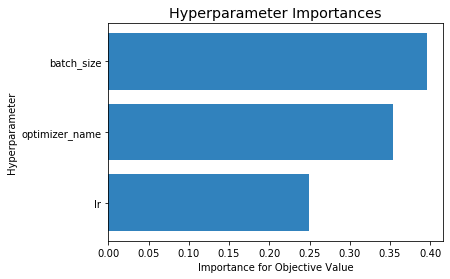

In [17]:
import matplotlib.pyplot as plt
fig = optuna.visualization.matplotlib.plot_param_importances(study)
#fig.show()
plt.savefig(name_training + '/param_importances.png', format="png",bbox_inches='tight')
plt.savefig(name_training + '/param_importances.pdf', format='pdf',bbox_inches='tight')


/tmp/ipykernel_3260892/937448550.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


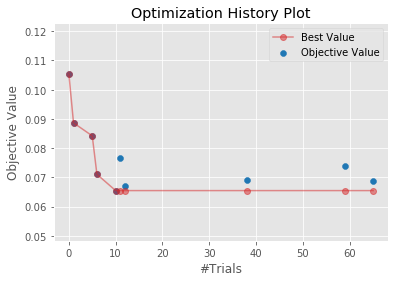

In [18]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)
#fig.show()
plt.savefig(name_training + '/optim_history.png', format="png",bbox_inches='tight')
plt.savefig(name_training + '/optim_history.pdf', format='pdf',bbox_inches='tight')

/tmp/ipykernel_3260892/2559100372.py:1: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_intermediate_values(study)
/tmp/ipykernel_3260892/2559100372.py:3: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.savefig(name_training + '/intermediate_values.png', format='png',bbox_inches='tight')
/tmp/ipykernel_3260892/2559100372.py:4: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.savefig(name_training + '/intermediate_values.pdf', format='pdf',bbox_inches='tight')
/tmp/ipykernel_3260892/2559100372.py:4: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.savefig(name_training + '/intermediate_values.pdf', for

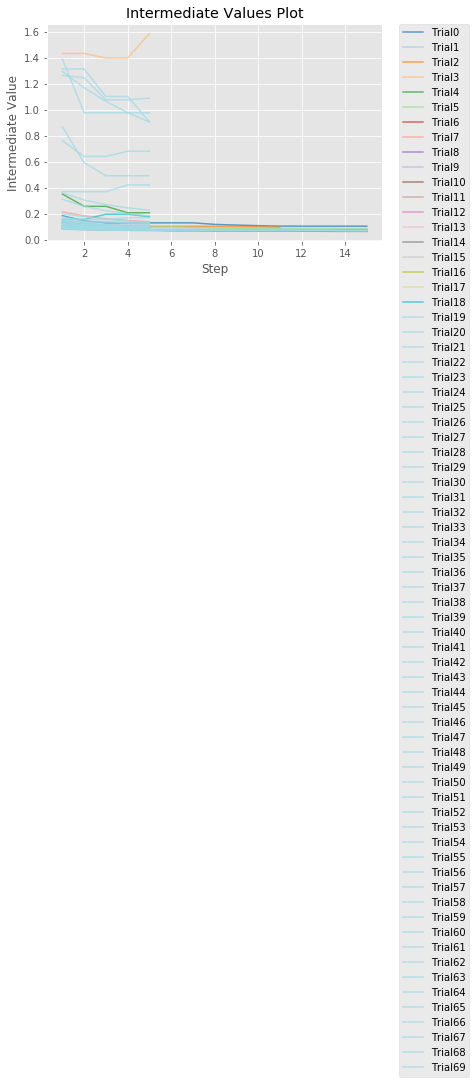

In [19]:
fig = optuna.visualization.matplotlib.plot_intermediate_values(study)
#fig.show()
plt.savefig(name_training + '/intermediate_values.png', format='png',bbox_inches='tight')
plt.savefig(name_training + '/intermediate_values.pdf', format='pdf',bbox_inches='tight')

/tmp/ipykernel_3260892/4256819052.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_slice(study)
/home/student-w-3/.local/lib/python3.8/site-packages/optuna/visualization/matplotlib/_slice.py:188: UserWarning: Attempting to set identical left == right == 0.9327306688681064 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim[0], xlim[1])


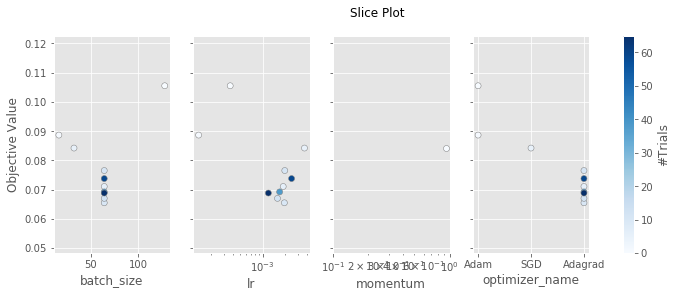

In [20]:
fig = optuna.visualization.matplotlib.plot_slice(study)
#fig.show()
plt.savefig(name_training + '/plot_slice.png', format='png',bbox_inches='tight')
plt.savefig(name_training + '/plot_slice.pdf', format='pdf',bbox_inches='tight')

/tmp/ipykernel_3260892/3816338908.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study)
[W 2022-04-27 17:40:13,465] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
[W 2022-04-27 17:40:16,213] Param momentum unique value length is less than 2.
[W 2022-04-27 17:40:21,270] Param momentum unique value length is less than 2.
[W 2022-04-27 17:40:23,883] Param momentum unique value length is less than 2.
[W 2022-04-27 17:40:23,885] Param momentum unique value length is less than 2.
[W 2022-04-27 17:40:23,886] Param momentum unique value length is less than 2.
[W 2022-04-27 17:40:23,886] Param momentum unique value length is less than 2.
[W 2022-04-27 17:40:28,910] Param momentum unique value length is less than 2.


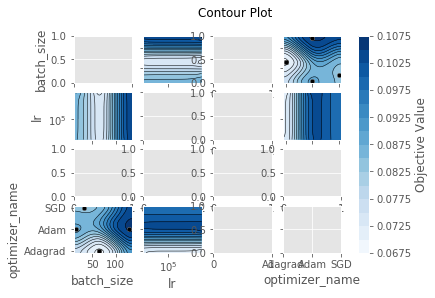

In [21]:
fig = optuna.visualization.matplotlib.plot_contour(study)
#fig.show()
plt.savefig(name_training + '/plot_contour.png', format='png',bbox_inches='tight')
plt.savefig(name_training + '/plot_contour.pdf', format='pdf',bbox_inches='tight')